## Imports

In [1]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt

In [2]:
%autosave 180

Autosaving every 180 seconds


## Generate the dataset

In [3]:
df = pd.DataFrame(np.random.randint(0, 2, size=(30, 8)), columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'])
df['y'] = df.sum(axis=1)
df

,x1,x2,x3,x4,x5,x6,x7,x8,y
0,0,0,1,1,0,1,1,0,4
1,0,0,1,0,1,1,0,0,3
2,0,1,0,0,1,1,1,0,4
3,0,0,1,1,1,0,1,0,4
4,0,1,0,0,0,0,0,0,1
5,1,1,1,1,0,1,0,0,5
6,0,0,0,0,1,1,1,1,4
7,1,0,0,0,1,1,1,1,5
8,0,1,0,0,1,0,1,1,4
9,1,0,0,0,0,0,1,0,2


## Adder with the Elman Recurrent Neural Network

We'll build an Elman Recurrent Neural Network to predict the sum of 8 bits. We have one neuron that has two inputs : the input bit $x_{n}$ and the previous output $f_{t-1}$.

As we want to have a linear model, the activation function will be the identity, and we don't need a bias.

<img src="archi.png">

In [158]:
class RNNAdder():
    
    def __init__(self):
        # Our two weights initialized randomly between -1 and 1
        self.Vx = np.random.normal(1.0, 0.5)
        self.Vf = np.random.normal(1.0, 0.5)
        
        # Learning rates
        self.lr_x = 0.001
        self.lr_f = 0.001
        
        # Number of features
        self.T = 0
        
        # Neuron output matrix
        self.f = None
        
        # Error
        self.err = []
        
        # Historic of weights
        self.hist_Vx = [self.Vx]
        self.hist_Vf = [self.Vf]
        
        # Historic of gradients
        self.hist_dVx = []
        self.hist_dVf = []
    
    def forward(self, X):
        self.f = np.zeros((X.shape[0], X.shape[1] + 1))
        
        for t in range(self.T):
            self.f[:, t + 1] = self.Vf * self.f[:, t] + self.Vx * X[:, t]
        
        return self.f[:, -1]
    
    def compute_sse(self, y_hat, y):
        sse = 0.5 * np.sum(np.square(y_hat - y))
        return sse
    
    def compute_mae(self, y_hat, y):
        mae = np.sum(np.absolute(y_hat - y)) / y_hat.shape[0]
        return mae
    
    def backward(self, X, y, y_hat):
        dVx = 0
        dVf = 0
        
        for t in range(self.T):
            dVx += np.sum((y_hat - y) * X[:, t]) * (self.Vf ** (self.T - t))
            dVf += np.sum((y_hat - y) * self.f[:, t - 1]) * (self.Vf ** (self.T - t))
            
        self.Vx -= self.lr_x * dVx
        self.Vf -= self.lr_f * dVf
        
        self.hist_Vx.append(self.Vx)
        self.hist_Vf.append(self.Vf)
        
        self.hist_dVx.append(dVx)
        self.hist_dVf.append(dVf)
        
    def plot_hist(self):
        plt.plot(np.arange(len(self.err)), self.err)
        plt.title('SSE')
        plt.show()
        plt.plot(np.arange(len(self.hist_Vx)), self.hist_Vx, label='Vx')
        plt.plot(np.arange(len(self.hist_Vf)), self.hist_Vf, label='Vf')
        plt.legend()
        plt.title('Weights')
        plt.show()
        plt.plot(np.arange(len(self.hist_dVx)), self.hist_dVx, label='dVx')
        plt.plot(np.arange(len(self.hist_dVf)), self.hist_dVf, label='dVf')
        plt.legend()
        plt.title('Gradients')
        plt.show()
    
    def fit(self, X, y, nb_epoch=50):
        self.T = X.shape[1]
        
        for k in range(nb_epoch):
            y_hat = self.forward(X)

            self.err.append(self.compute_sse(y_hat, y))

            self.backward(X, y, y_hat)
            
        self.plot_hist()
        
    def predict(self, X, y):
        # Compute prediction
        y_hat = self.forward(X)
        
        # Compute Mean Absolute Error
        mae = self.compute_mae(y_hat, y)
        
        # Print results
        for i in range(X.shape[0]):
            print('Seq:', X[i], '| y =', y[i], '| y_hat =', y_hat[i])
        print('MAE =', mae)

C:\Users\maxim\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in multiply
C:\Users\maxim\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in square
C:\Users\maxim\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in multiply
C:\Users\maxim\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in double_scalars
C:\Users\maxim\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in multiply
C:\Users\maxim\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in double_scalars
C:\Users\maxim\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply


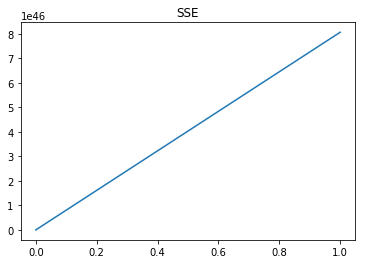

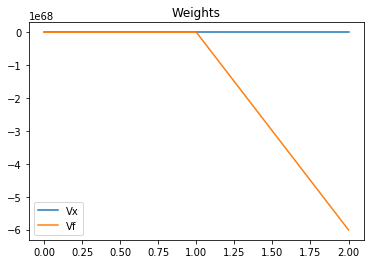

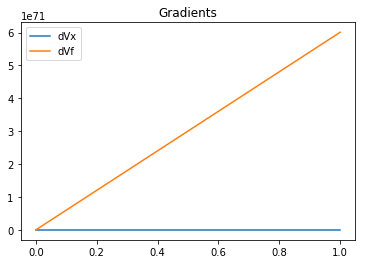

In [159]:
X, y = df.drop(columns='y').values, df['y'].values
train_X, test_X, train_y, test_y = X[:25], X[25:], y[:25], y[25:]

model = RNNAdder()
model.fit(train_X, train_y, nb_epoch=100)

In [160]:
model.predict(test_X, test_y)

Seq: [1 0 0 1 0 0 0 1] | y = 3 | y_hat = nan
Seq: [1 1 0 0 0 0 0 0] | y = 2 | y_hat = nan
Seq: [0 0 1 1 1 0 0 0] | y = 3 | y_hat = nan
Seq: [1 1 1 1 1 0 0 1] | y = 6 | y_hat = nan
Seq: [1 0 0 0 1 0 0 0] | y = 2 | y_hat = nan
MAE = nan


In [161]:
print(model.hist_Vf[:10])
print(model.hist_Vx[:10])

[1.688663861436845, -1178.7284881069922, -6.008926946492598e+68, nan, nan, nan, nan, nan, nan, nan]
[0.6350369379558484, -44.92000410795838, -4.231171974676873e+45, nan, nan, nan, nan, nan, nan, nan]


In [162]:
print(model.hist_dVf[:10])
print(model.hist_dVx[:10])

[1180417.151968429, 6.008926946492598e+71, nan, nan, nan, nan, nan, nan, nan, nan]
[45555.04104591422, 4.2311719746768725e+48, nan, nan, nan, nan, nan, nan, nan, nan]


Looking at the gradients, we can observe the exploding gradients problem. To avoid it, let's try to implement two other backpropagation algorithm.
## Resilient backpropagation

In [163]:
class ResilientRNNAdder(RNNAdder):
    
    def __init__(self):
        RNNAdder.__init__(self)
        
        # Delta weights
        self.delta_x = 0.001
        self.delta_f = 0.001
        
        # Learning rate limits
        self.max_delta = 50
        self.min_delta = 1e-6
        
        # Learning rate factors
        self.eta_p = 1.2
        self.eta_n = 0.5
        
    def find_lr_factor(self, grad, prev_grads):
        # If the list is empty (first iteration)
        if not prev_grads:
            return 1
        else:
            if grad * prev_grads[-1] > 0:
                return self.eta_p
            else:
                return self.eta_n
        
    def resilient_backward(self, X, y, y_hat):
        dVx = 0
        dVf = 0
        
        # Compute the same gradients
        for t in range(self.T):
            dVx += (np.sum((y_hat - y) * X[:, t]) * (self.Vf ** (self.T - t)))
            dVf += (np.sum((y_hat - y) * self.f[:, t - 1]) * (self.Vf ** (self.T - t)))
            
        # Update the deltas
        self.delta_x *= self.find_lr_factor(dVx, self.hist_dVx)
        self.delta_f *= self.find_lr_factor(dVf, self.hist_dVf)
        
        # Limit deltas
        if self.delta_x > self.max_delta:
            self.delta_x = self.max_delta
        elif self.delta_x < self.min_delta:
            self.delta_x = self.min_delta
        if self.delta_f > self.max_delta:
            self.delta_f = self.max_delta
        elif self.delta_f < self.min_delta:
            self.delta_f = self.min_delta
        
        # Update the weights
        self.Vx -= np.sign(dVx) * self.delta_x
        self.Vf -= np.sign(dVf) * self.delta_f
        
        self.hist_Vx.append(self.Vx)
        self.hist_Vf.append(self.Vf)
        
        self.hist_dVx.append(dVx)
        self.hist_dVf.append(dVf)
        
    def fit(self, X, y, nb_epoch=50):
        self.T = X.shape[1]
        
        for k in range(nb_epoch):
            y_hat = self.forward(X)

            self.err.append(self.compute_sse(y_hat, y))

            self.resilient_backward(X, y, y_hat)
            
        self.plot_hist()

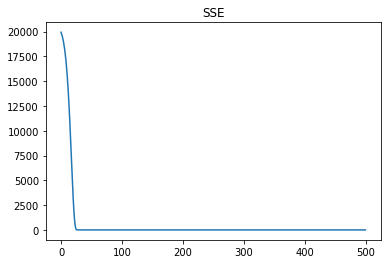

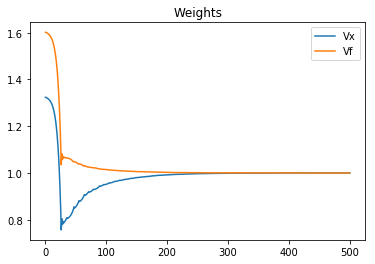

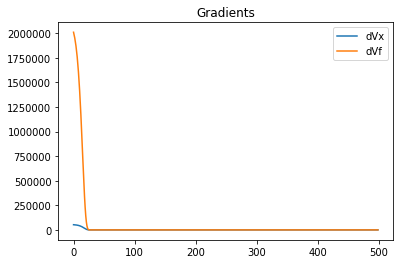

In [164]:
model = ResilientRNNAdder()
model.fit(train_X, train_y, nb_epoch=500)

In [165]:
print(model.hist_Vf[-15:])
print(model.hist_Vx[-15:])

[1.0000158198156126, 1.0000148198156127, 1.0000158198156126, 1.0000148198156127, 1.0000158198156126, 1.0000148198156127, 1.0000158198156126, 1.0000148198156127, 1.0000158198156126, 1.0000148198156127, 1.0000158198156126, 1.0000148198156127, 1.0000158198156126, 1.0000148198156127, 1.0000158198156126]
[0.9999479312205555, 0.9999469312205554, 0.9999479312205555, 0.9999469312205554, 0.9999479312205555, 0.9999469312205554, 0.9999479312205555, 0.9999469312205554, 0.9999479312205555, 0.9999469312205554, 0.9999479312205555, 0.9999469312205554, 0.9999479312205555, 0.9999469312205554, 0.9999479312205555]


We can see that both gradients converge to **1**, which is a logical value to get a functionning adder.

Now let's try to predict the testing set to verify the result.

In [166]:
model.predict(test_X, test_y)

Seq: [1 0 0 1 0 0 0 1] | y = 3 | y_hat = 3.000017809329502
Seq: [1 1 0 0 0 0 0 0] | y = 2 | y_hat = 2.000101518345079
Seq: [0 0 1 1 1 0 0 0] | y = 3 | y_hat = 3.0000336263192717
Seq: [1 1 1 1 1 0 0 1] | y = 6 | y_hat = 6.000083075884907
Seq: [1 0 0 0 1 0 0 0] | y = 2 | y_hat = 2.0000540583662794
MAE = 5.8017649007879865e-05
